In [23]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm


from datasets.arrow_dataset import Dataset

In [24]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
train_data, test_data  = datasets.load_dataset("imdb", split=["train", "test"])
using_dbpedia = False

In [25]:
train_data, test_data = datasets.load_dataset("fancyzhx/dbpedia_14", split=["train", "test"])
using_dbpedia = True

In [26]:
train_data : Dataset
test_data : Dataset

## prepare

###### for now reduce in size to save time

In [27]:
### sample and reduce poth splits to 10% of the original size


print(f"Original train_data length: {len(train_data)}")
print(f"Original test_data length: {len(test_data)}")


train_data = train_data.select(indices=np.random.choice(len(train_data), len(train_data)//10))
test_data = test_data.select(indices=np.random.choice(len(test_data), len(test_data)//10))

print(f"Reduced train_data length: {len(train_data)}")
print(f"Reduced test_data length: {len(test_data)}")

Original train_data length: 560000
Original test_data length: 70000
Reduced train_data length: 56000
Reduced test_data length: 7000


In [28]:
subclass_names = [
    'company', 'educational institution', 'artist', 'athlete', 
    'office holder', 'mean of transportation', 'building', 
    'natural place', 'village', 'animal', 'plant', 
    'album', 'film', 'writtenWork'
]



ont_1_mapping = {
        0: 1, # company : other
        1: 1, # educational institution : other
        2: 0, # artist : person
        3: 0, # athlete : person
        4: 0, # office holder : person
        5: 1, # mean of transportation : other
        6: 2, # building : place
        7: 2, # natural place : place
        8: 2, # village : place
        9: 3, # animal : organism
        10: 3, # plant : organism
        11: 4, # album : artwork
        12: 4, # film : artwork
        13: 4, # writtenWork : artwork
    }



superclass_names = ["other", "person", "place", "organism", "artwork"]

In [ ]:


def change_labels(batch, use_superclasses_as_label=True):

    labels = batch["label"]

    superclasses = [ont_1_mapping[subclass] for subclass in labels]


    batch["subclasses"] = labels
    batch["superclasses"] = superclasses

    if use_superclasses_as_label:
        # Replace `label` with `superclass`
        batch["labels"] = superclasses

    return batch

# Apply padding function to each batch in the dataset
# dataset = test_data.map(pad_to_max_length, batched=True, batch_size=len(test_data))

train_data = train_data.map(change_labels, batched=True, batch_size=len(train_data))
test_data = test_data.map(change_labels, batched=True, batch_size=len(test_data))

Map:   0%|          | 0/56000 [00:00<?, ? examples/s]

<class 'list'>
56000


Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

<class 'list'>
7000


In [30]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [31]:
###use  either the "tiles" or the "content" for tokenizations 
def tokenize_example_content(example, tokenizer, max_length):
    tokens = tokenizer(example["content"])[:max_length]
    return {"tokens": tokens}

def tokenize_example_title(example, tokenizer, max_length):
    tokens = tokenizer(example["title"])[:max_length]
    return {"tokens": tokens}



def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [32]:
max_length = 256

if using_dbpedia:
    train_data = train_data.map(
        tokenize_example_content, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
    )
    test_data = test_data.map(
        tokenize_example_content, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
    )
else:

    train_data = train_data.map(
        tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
    )
    test_data = test_data.map(
        tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
    )

Map:   0%|          | 0/56000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [33]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [34]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [35]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [36]:
vocab.set_default_index(unk_index)

In [37]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [38]:
def test_debug(batch):
    labels = batch["labels"]
    lables_np = np.array(labels)

    unique = np.unique(lables_np)
    print(unique)
    return batch


train_data = train_data.map(test_debug, batched=True, batch_size=len(train_data))

Map:   0%|          | 0/42000 [00:00<?, ? examples/s]

[0 1 2 3 4]


In [39]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/42000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [40]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "subclasses", "superclasses"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "subclasses", "superclasses"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "subclasses", "superclasses"])


##TODO retain the subclass data...

In [41]:
def pad_to_max_length(batch):
    # Extract `ids` as a list of tensors
    ids = batch["ids"]
    
    # Pad each tensor in `ids` to the same length
    padded_ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=pad_index)
    
    # Truncate to max_seq_len if necessary
    if padded_ids.shape[1] > max_length:
        padded_ids = padded_ids[:, :max_length]
    
    # Add padded data back to batch
    batch["padded_ids"] = [padded_ids[i] for i in range(len(padded_ids))]
    return batch

# Apply padding function to each batch in the dataset
# dataset = test_data.map(pad_to_max_length, batched=True, batch_size=len(test_data))

train_data = train_data.map(pad_to_max_length, batched=True, batch_size=len(train_data))
valid_data = valid_data.map(pad_to_max_length, batched=True, batch_size=len(valid_data))
test_data = test_data.map(pad_to_max_length, batched=True, batch_size=len(test_data))


Map:   0%|          | 0/42000 [00:00<?, ? examples/s]

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [42]:
for jj in train_data:
    print(jj.keys())
    for kk in jj.keys():
        print(type(jj[kk]))

    print(jj["padded_ids"])
    print(jj["ids"])
    break

dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([   0,    6,    7, 1332, 2147,   27,  222,    4,  283,    2,    7, 4110,
         356,   23, 6519,    4,    3,  477,  755,    2,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,

In [43]:
db_train = train_data
print(type(db_train))
print(db_train.__len__())

for i in range(10):
    print(db_train[i]["padded_ids"].size())
    print(db_train[i].keys())

<class 'datasets.arrow_dataset.Dataset'>
42000
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])
torch.Size([256])
dict_keys(['label', 'subclasses', 'superclasses', 'ids', 'padded_ids'])


In [44]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["padded_ids"] for i in batch]
        # batch_ids = nn.utils.rnn.pad_sequence(
        #     batch_ids, padding_value=pad_index, batch_first=True
        # )
        batch_ids = torch.stack(batch_ids)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [51]:
def get_collate_fn_2(pad_index):
    def collate_fn(batch):
        batch_ids = [i["padded_ids"] for i in batch]
        # batch_ids = nn.utils.rnn.pad_sequence(
        #     batch_ids, padding_value=pad_index, batch_first=True
        # )
        batch_ids = torch.stack(batch_ids)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)

        batch_subclasses = [i["subclasses"] for i in batch]
        batch_subclasses = torch.stack(batch_subclasses)

        batch_superclasses = [i["superclasses"] for i in batch]
        batch_superclasses = torch.stack(batch_superclasses)

        batch = {"ids": batch_ids, "label": batch_label, "subclasses": batch_subclasses, "superclasses": batch_superclasses}
        return batch

    return collate_fn

In [52]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn_2(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [54]:
batch_size = 320

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [55]:
print("number of training samples: ", len(train_data))
print(1875-(batch_size * 5))

number of training samples:  42000
275


In [56]:
print(f"Number of train batches: {len(train_data_loader)}")
print(f"Number of valid batches: {len(valid_data_loader)}")
print(f"Number of test batches: {len(test_data_loader)}")

Number of train batches: 132
Number of valid batches: 44
Number of test batches: 22


## model defintion

In [57]:
def register_save_activations_hook(model, model_activation_layer, activations_list):
    """Registers a forward pass hook that saves activations.
    
    Args:
        model(nn.Module): A PyTorch model.
        model_activation_layer(str): The name of the module in the network that
            produces the activations of interest.
        activations_list(List[torch.Tensor]) The list in which we should store the
            model activations.
    """
    def save_activations(model, inp, out):
        # print(f"save_activations: {out.size()}")
        activs = out.view(out.size(0), -1).detach().cpu()       
        activations_list.append(activs)

    for name, m in model.named_modules():
        if name == model_activation_layer or \
          (isinstance(model, torch.nn.DataParallel) and \
           name.replace('module.', '') == model_activation_layer):
            return m.register_forward_hook(save_activations)
    return None

In [93]:
class CNN(nn.Module):



    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

        ## last layer name
        self.activation_layer_name =f"convs.{len(filter_sizes)-1}"

    def _init_activations_hook(self, model, activations_list, layer_name):
        """Initializes the forward hook to save model activations."""
        # if isinstance(model, torch.nn.DataParallel):
        #     activation_layer = f"model.module.{layer_name}"
        # else:
        #     activation_layer = f"model.{layer_name}"
        activation_layer = layer_name
        activations_handle = register_save_activations_hook(model, activation_layer,
                                                            activations_list)
        if activation_layer is not None:
            assert activations_handle is not None, \
                f'No hook registered for activation_layer={activation_layer}'
        return activations_handle


    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]

        # print(conved[0].shape)
        pooled = [conv.max(dim=-1).values for conv in conved]

        # print(pooled[0].shape)
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [94]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = len(train_data.unique("label"))
dropout_rate = 0.25

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

## training settigs and hyper parameters

In [95]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,854,114 trainable parameters


In [96]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [97]:
model.apply(initialize_weights)

CNN(
  (embedding): Embedding(21332, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=14, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [98]:
vectors = torchtext.vocab.GloVe()

In [99]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [100]:
print(pretrained_embedding.shape)

torch.Size([21332, 300])


In [101]:
model.embedding.weight.data = pretrained_embedding

In [102]:
optimizer = optim.Adam(model.parameters())

In [103]:
criterion = nn.CrossEntropyLoss()

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [105]:
model = model.to(device)
criterion = criterion.to(device)

In [106]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

## training

In [107]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_activations = {}
    epoch_labels = []
    epoch_subclasses = []
    epoch_superclasses = []


    activation_handles = []

    for conv in ["convs.0", "convs.1", "convs.2"]:
    
        conv_activations = []
        activations_handle = model._init_activations_hook(model, conv_activations, conv)
        activation_handles.append(activations_handle)
        epoch_activations[conv] = conv_activations
    debug_counter = 0

    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        subclasses = batch["subclasses"].to(device)
        superclasses = batch["superclasses"].to(device)

        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        epoch_labels.append(label.detach().cpu())
        epoch_subclasses.append(subclasses.detach().cpu())
        epoch_superclasses.append(superclasses.detach().cpu())
        
        # print(label.shape)
        # print(epoch_activations[-1].shape)

        # print("debug_counter: ", debug_counter)
        debug_counter += 1

    for handle in activation_handles:
        handle.remove()


    epoch_outputs = {
        "loss": np.mean(epoch_losses),
        "accuracy": np.mean(epoch_accs),
        "activations": epoch_activations,
        "labels": epoch_labels,
        "subclasses": epoch_subclasses,
        "superclasses": epoch_superclasses
    }

    # return np.mean(epoch_losses), np.mean(epoch_accs), epoch_activations, epoch_labels
    return epoch_outputs

In [108]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_activations = {}
    epoch_labels = []
    epoch_subclasses = []
    epoch_superclasses = []


    activation_handles = []

    for conv in ["convs.0", "convs.1", "convs.2"]:
    
        conv_activations = []
        activations_handle = model._init_activations_hook(model, conv_activations, conv)
        activation_handles.append(activations_handle)
        epoch_activations[conv] = conv_activations
        
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            subclasses = batch["subclasses"].to(device)
            superclasses = batch["superclasses"].to(device)
            
            
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            epoch_labels.append(label.detach().cpu())
            epoch_subclasses.append(subclasses.detach().cpu())
            epoch_superclasses.append(superclasses.detach().cpu())

    for handle in activation_handles:
        handle.remove()


    epoch_outputs = {
        "loss": np.mean(epoch_losses),
        "accuracy": np.mean(epoch_accs),
        "activations": epoch_activations,
        "labels": epoch_labels,
        "subclasses": epoch_subclasses,
        "superclasses": epoch_superclasses
    }

    # return np.mean(epoch_losses), np.mean(epoch_accs), epoch_activations, epoch_labels
    return epoch_outputs
    # return np.mean(epoch_losses), np.mean(epoch_accs), epoch_activations, epoch_labels

In [109]:
from copy import deepcopy

state_dict = deepcopy(model.state_dict()) 

In [83]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [84]:
imdb_loader_train = train_data_loader
imdb_loader_valid = valid_data_loader

In [85]:
pedia_loader_train = train_data_loader
pedia_loader_valid = valid_data_loader

In [86]:

for batch in imdb_loader_train:
    print(batch["ids"].size())
    print(batch["label"].size())
    


torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320, 256])
torch.Size([320])
torch.Size([320,

In [111]:
n_epochs = 4
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

outputs = {}

for epoch in range(n_epochs):

    t_outs = train(
        train_data_loader, model, criterion, optimizer, device
    )
    # train_loss, train_acc, train_activations, train_labels, train_subclasses, train_superclasses = t_outs["loss"], t_outs["accuracy"], t_outs["activations"], t_outs["labels"], t_outs["subclasses"], t_outs["superclasses"]




    v_outs = evaluate(valid_data_loader, model, criterion, device)
    # valid_loss, valid_acc, val_activations, val_labels

    metrics["train_losses"].append(t_outs["loss"])
    metrics["train_accs"].append(t_outs["accuracy"])

    metrics["valid_losses"].append(v_outs["loss"])
    metrics["valid_accs"].append(v_outs["accuracy"])
    
    
    
    if v_outs["loss"] < best_valid_loss:
        best_valid_loss = v_outs["loss"]
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")

    train_loss = t_outs["loss"]
    train_acc = t_outs["accuracy"]

    valid_loss = v_outs["loss"]
    valid_acc = v_outs["accuracy"]

    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")



    test = {}

    for key, value in tqdm.tqdm(t_outs["activations"].items(), desc="concatting activations batches"):
        t_outs["activations"][key] = torch.cat(value, dim=0)
        
    for key, value in tqdm.tqdm(v_outs["activations"].items(), desc="concatting activations batches"):
        v_outs["activations"][key] = torch.cat(value, dim=0)

    # train_activations = torch.cat(train_activations, dim=0)
    # val_activations = torch.cat(val_activations, dim=0)

    t_outs["labels"] = torch.cat(t_outs["labels"], dim=0)
    v_outs["labels"] = torch.cat(v_outs["labels"], dim=0)


    t_outs["subclasses"] = torch.cat(t_outs["subclasses"], dim=0)
    v_outs["subclasses"] = torch.cat(v_outs["subclasses"], dim=0)

    t_outs["superclasses"] = torch.cat(t_outs["superclasses"], dim=0)
    v_outs["superclasses"] = torch.cat(v_outs["superclasses"], dim=0)



    ### save activations

    # t_outs = {
    #     "activations": train_activations,
    #     "labels": train_labels
    # }
    # val_outputs = {
    #     "activations": val_activations,
    #     "labels": val_labels
    # }
    outputs[epoch] = {"train": t_outs, "val": v_outs}

evaluating...: 100%|██████████| 44/44 [00:01<00:00, 31.83it/s]


epoch: 0
train_loss: 0.499, train_acc: 0.852
valid_loss: 0.099, valid_acc: 0.971


evaluating...: 100%|██████████| 44/44 [00:01<00:00, 31.08it/s]


epoch: 1
train_loss: 0.103, train_acc: 0.971
valid_loss: 0.074, valid_acc: 0.978


evaluating...: 100%|██████████| 44/44 [00:01<00:00, 34.89it/s]


epoch: 2
train_loss: 0.066, train_acc: 0.981
valid_loss: 0.065, valid_acc: 0.981


evaluating...: 100%|██████████| 44/44 [00:01<00:00, 36.77it/s]


epoch: 3
train_loss: 0.045, train_acc: 0.987
valid_loss: 0.060, valid_acc: 0.983


concatting activations batches: 100%|██████████| 3/3 [00:00<00:00, 22.29it/s]


In [87]:
for n,m in model.named_modules():
    print(n)


embedding
convs
convs.0
convs.1
convs.2
fc
dropout


In [112]:


for epoch in outputs:
    dicttt : dict = outputs[epoch]
    t_outs = dicttt["train"]
    print(t_outs.keys())
    # activations_t = t_outs["activations"]
    # print(type(activations_t))
    # for key in activations_t.keys():
    #     print(key)
    #     print(activations_t[key].size())
    #     print(activations_t[key].dtype)
        



dict_keys(['loss', 'accuracy', 'activations', 'labels', 'subclasses', 'superclasses'])
dict_keys(['loss', 'accuracy', 'activations', 'labels', 'subclasses', 'superclasses'])
dict_keys(['loss', 'accuracy', 'activations', 'labels', 'subclasses', 'superclasses'])
dict_keys(['loss', 'accuracy', 'activations', 'labels', 'subclasses', 'superclasses'])


In [113]:
print(model)

CNN(
  (embedding): Embedding(21332, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=14, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


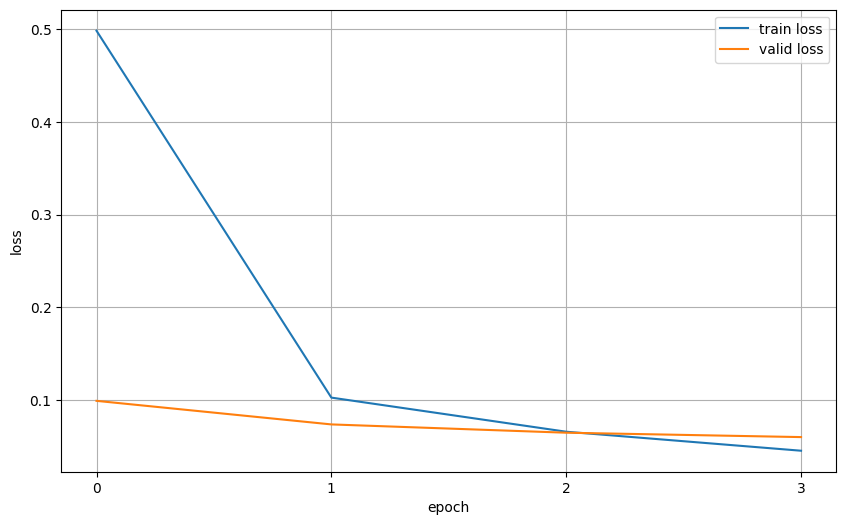

In [114]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

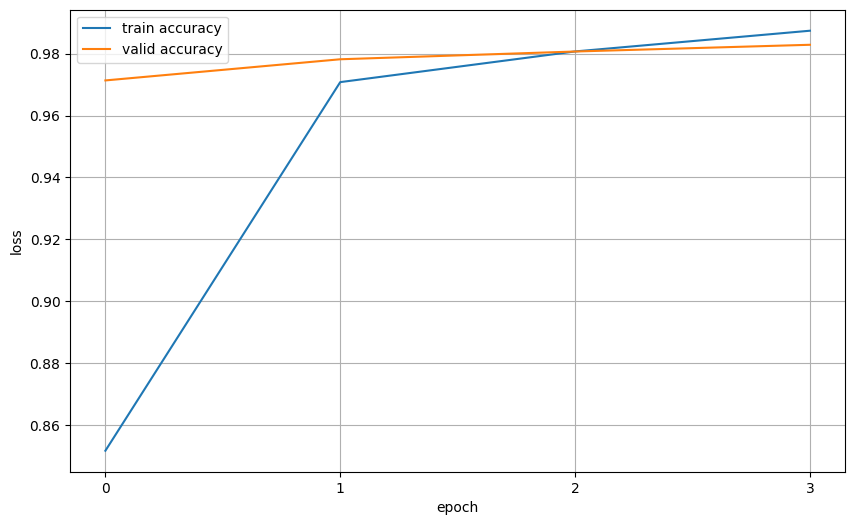

In [115]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [48]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc, test_activations, test_epoch_labels = evaluate(test_data_loader, model, criterion, device)

evaluating...:  18%|█▊        | 4/22 [00:00<00:00, 38.39it/s]

evaluating...: 100%|██████████| 22/22 [00:00<00:00, 48.48it/s]


In [117]:
last_epoch  = outputs[n_epochs-1]


In [118]:
torch.save(last_epoch, "last_epoch.pt")

In [116]:
torch.save(outputs, "outputs.pt")

In [49]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.066, test_acc: 0.982


In [48]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [49]:
text = "This film is terrible!"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.954708456993103)

In [50]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.921493649482727)

In [51]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.9487431049346924)

In [52]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(12, 0.9126440286636353)

In [51]:
activations = torch.load("outputs.pt")
print(activations.keys())
forth_epoch = activations[3]
print(forth_epoch.keys())

KeyboardInterrupt: 

In [119]:
print(type(forth_epoch["train"]))
print(len(forth_epoch["train"]))

<class 'list'>
4


In [128]:
print(forth_epoch["train"][0].size())

torch.Size([512, 25000])


In [133]:
xxx = forth_epoch["train"][0]

In [135]:
print(xxx.size())

yyy = xxx.view(xxx.size(0), -1)
print(yyy.size())

torch.Size([512, 25000])
torch.Size([512, 25000])
